# 1D parameter estimation using Jax+Blackjax (MCMC)

This example will cover:

 - Use the Jax-based GP kernel
 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [1]:
from gptide import covjax as cov
from gptide import GPtideJax
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az


from gptide import mcmcjax


/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Generate some data

Start off with the same kernel as Example 1 and generate some data.

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 1.5
ℓ = 100
covfunc = cov.expquad_1d

###
# Domain size parameters
dx = 25.
N = 100
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideJax(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)


Text(0.5, 0, 'x')

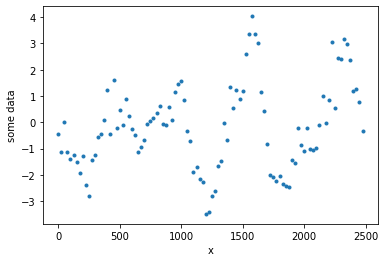

In [3]:
plt.figure()
plt.plot(xd, yd,'.')
plt.ylabel('some data')
plt.xlabel('x')

## Inference

We now use the `gptide.mcmcjax` function do the parameter estimation. This uses the `blackjax` NUTS sampler.


In [4]:
# Testing function
# Truncated normal was not in jax==0.2.22
from jax.scipy import special as sc
import scipy.stats as ostats
from gptide.stats import truncnorm
import jax.scipy.stats as jstats

import jax.numpy as jnp
twopi = 2*jnp.pi

def psi(x):
    return 1/jnp.sqrt(twopi)*jnp.exp(-0.5*x*x)

def bigpsi(x):
    return 0.5*(1 + sc.erf(x/jnp.sqrt(2)))
    
def truncnorm_pdf(x, mu, sigma, lower, upper ): 
    
    cff0 = (x-mu)/sigma
    cff1 = (upper-mu)/sigma
    cff2 = (lower-mu)/sigma
    
    # This doesn't work...
    #     if (x<upper) & (x>lower):
    #         return 1/sigma * psi(cff0) / (bigpsi(cff1) - bigpsi(cff2))
    #     else:
    #         return 0.
    
    pdf = 1/sigma * psi(cff0) / (bigpsi(cff1) - bigpsi(cff2))
    return jnp.where((x<upper) & (x>lower), pdf, 0.)

def truncnorm_logpdf(x, mu, sigma, lower, upper ):
    
    return jnp.log(truncnorm_pdf(x, mu, sigma, lower, upper ))
    
    
def invgamma_logpdf( x, a):
    return -(a+1) * jnp.log(x) - sc.gammaln(a) - 1.0/x



class JaxPrior(object):
    
    def __init__(self, distname, *args):
        self.args = args
        self.distname = distname
        
        if self.distname in ['invgamma','truncnorm']:
            self.statsclass = None
        else:
            self.statsclass = getattr(jstats, distname)
        
        if self.distname is 'truncnorm':
            self._sp = truncnorm(*self.args)
        else:
            self._sp = getattr(ostats, distname)(*self.args)
        
    def logpdf(self, value):
        if self.distname is 'invgamma':
            return invgamma_logpdf(value, *self.args)
        
        elif self.distname is 'truncnorm':
            return truncnorm_logpdf(value, *self.args)
        else:
            return self.statsclass.logpdf(value, *self.args)
    
    def rvs(self):
        return self._sp.rvs()
    

In [5]:
initvals = None

# noise_prior = mcmcjax.JaxPrior('invgamma', 2. ,)
# covparams_priors = [ 
#      mcmcjax.JaxPrior('invgamma', 1,), 
#      mcmcjax.JaxPrior('norm', 125, 50)
# ]

# noise_prior      =JaxPrior('norm', 0.4, 0.25)                 # noise - true value 0.5
# covparams_priors = [JaxPrior('norm', 1, 1),   # η - true value 1.5
#                     JaxPrior('norm', 125, 50)  # ℓ - true value 100
#                    ]

noise_prior      =mcmcjax.JaxPrior('truncnorm', 0.4, 0.25, 1e-15, 100.)                 # noise - true value 0.5
covparams_priors = [mcmcjax.JaxPrior('truncnorm', 1, 1, 1e-15, 100.),   # η - true value 1.5
                    mcmcjax.JaxPrior('truncnorm', 125, 50, 1e-15, 10000.)  # ℓ - true value 100
                   ]

In [6]:
noise_prior.logpdf(99)

DeviceArray(-inf, dtype=float64)

In [7]:
# Initial guess of the noise and covariance parameters (these can matter)

states, priors_out = mcmcjax.mcmcjax( xd, 
                        yd, 
                        covfunc, 
                        covparams_priors,
                        noise_prior,
                        nwarmup=500,
                        niter=1000,
                        )



Running window adaptation



Iteration 50 / 1,000
Iteration 100 / 1,000
Iteration 150 / 1,000
Iteration 200 / 1,000
Iteration 250 / 1,000
Iteration 300 / 1,000
Iteration 350 / 1,000
Iteration 400 / 1,000
Iteration 450 / 1,000
Iteration 500 / 1,000
Iteration 550 / 1,000
Iteration 600 / 1,000
Iteration 650 / 1,000
Iteration 700 / 1,000
Iteration 750 / 1,000
Iteration 800 / 1,000
Iteration 850 / 1,000
Iteration 900 / 1,000
Iteration 950 / 1,000
Iteration 1,000 / 1,000


In [8]:
samples=np.asarray(states[0])
samples.shape


(1000, 3)

## Find sample with highest log prob

In [9]:
#i = np.argmax(log_prob)
#MAP = samples[i, :]
# Not really the MAP but...
MAP = samples.mean(axis=0)

print('Noise (true): {:3.2f}, Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('ℓ (true): {:3.2f}, ℓ (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('η (true): {:3.2f}, η (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))


Noise (true): 0.50, Noise (mcmc): 0.53
ℓ (true): 1.50, ℓ (mcmc): 1.58
η (true): 100.00, η (mcmc): 94.19


## Posterior density plot

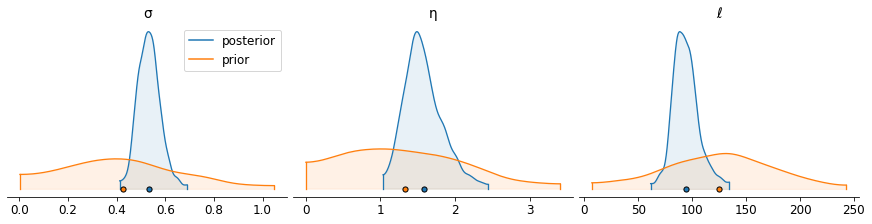

In [10]:
labels = ['σ','η','ℓ']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 3),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

## Posterior corner plot

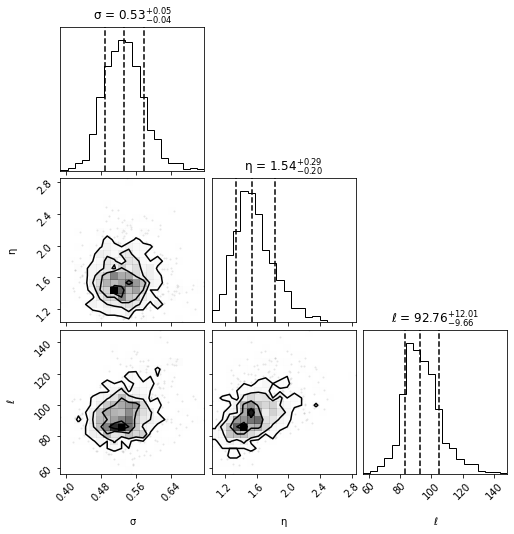

In [11]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

In [12]:
xo = np.arange(0,dx*N,dx/3)[:,None]

OI = GPtideJax(xd, xo, MAP[0], covfunc, MAP[1:], 
             P=1, mean_func=None)

out_map = OI.conditional(yd)

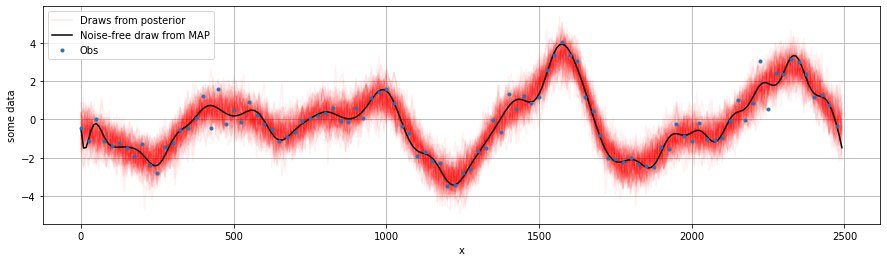

In [13]:
plt.figure(figsize=(15, 4))
plt.ylabel('some data')
plt.xlabel('x')

key = None
for i, draw in enumerate(np.random.uniform(0, samples.shape[0], 100).astype(int)):
    sample = samples[draw, :]
    
    OI = GPtideJax(xd, xo, sample[0], covfunc, sample[1:], 
             P=1, mean_func=None, key=key) 
    out_samp = OI.conditional(yd)
    # Need to update the key in this loop
    key = OI.key

    plt.plot(xo, out_samp, 'r', alpha=0.05, label=None)
    
plt.plot(xo, out_samp, 'r', alpha=0.1, label='Draws from posterior') # Just for legend
    
OI = GPtideJax(xd, xo, 0, covfunc, MAP[1:], 
             P=1, mean_func=None)
out_map = OI.conditional(yd)

plt.plot(xo, out_map, 'k', label='Noise-free draw from MAP')
plt.plot(xd, yd,'.', label='Obs')
plt.legend()
plt.grid()
